In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mwparserfromhell

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Loading Data

And correct some date inconcistencies

### From early version of Emma's code

In [2]:
# Read the file into a list of lines
with open('wiki-RfA.txt', 'r') as file:
    lines = file.readlines()

# Create a list of dictionaries, where each dictionary represents a record
df = []
current_entry = {}

# Iterate through each line, current_entry = one log entry with all columns, df = list of all votee/voter pairs
for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(':', 1)
        current_entry[key] = value
    else:
        df.append(current_entry)
        current_entry = {}

# Append  last record
if current_entry:
    df.append(current_entry)

# Convert into DataFrame and store in csv
df = pd.DataFrame(df)
df.columns = ['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment']

df.to_csv('wiki-RfA.csv')

# Set Nan values
# replace field that's entirely space (or empty) with NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# replace inconsistent date
df['Date'] = df['Date'].str.replace('Julu ', 'July ')
df['Date'] = df['Date'].str.replace('Janry ', 'January ')
df['Date'] = df['Date'].str.replace('Mya ', 'May ')
df['Date'] = df['Date'].str.replace('Jan ', 'January ')
df['Date'] = df['Date'].str.replace('Feb ', 'February ')
df['Date'] = df['Date'].str.replace('Mar ', 'March ')
df['Date'] = df['Date'].str.replace('Apr ', 'April ')
df['Date'] = df['Date'].str.replace('Jun ', 'June ')
df['Date'] = df['Date'].str.replace('Jul ', 'July ')
df['Date'] = df['Date'].str.replace('Aug ', 'August ')
df['Date'] = df['Date'].str.replace('Sep ', 'September ')
df['Date'] = df['Date'].str.replace('Oct ', 'October ')
df['Date'] = df['Date'].str.replace('Nov ', 'November ')
df['Date'] = df['Date'].str.replace('Dec ', 'December ')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M, %d %B %Y', errors='coerce')

## Information Extraction from Comments

First create a parsed column with only text infromation from Wikitext (markup language) 

In [4]:
df.Comment = df.Comment.fillna('')
df["Parsed_Comment"] = df.Comment.apply(lambda x: mwparserfromhell.parse(x).strip_code())

### Cosinus Similarity

In [5]:
def tf_idf_matrix(comments):
    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer(stop_words='english', max_features= 5000)
    tfidf_matrix = vectorizer.fit_transform(comments.values())
    return tfidf_matrix

In [6]:
def get_idx_lower_bound(keys):
    keys = [item[1] for item in keys]
    lower = min(keys)
    return lower

def get_idx_upper_bound(keys):
    keys = [item[1] for item in keys]
    upper = max(keys)
    return upper

In [7]:
#Group by Target
grouped_by_target = df.groupby('Target').apply(lambda x: list((enumerate(zip(x['Source'], x['Parsed_Comment'])))))
grouped_by_target = grouped_by_target.apply(lambda x: [(item[1][0], item[0], item[1][1]) for item in x]).reset_index()
grouped_by_target = grouped_by_target.rename(columns={0:'Text'})

#Build UID for all pairs of (SRC, Comment)
global_index = 0
for df_index, row in grouped_by_target.iterrows():
    length_of_current_list = len(row.Text)
    mrange = range(global_index, global_index+length_of_current_list)
    global_index += length_of_current_list
    new_list = [(item[0], idx, item[2]) for item, idx in zip(row.Text, mrange)]
    grouped_by_target.at[df_index, 'Text'] = new_list

#Format to have dictionary to be sure to access things in the right order
grouped_by_target.Text = grouped_by_target.Text.apply(lambda x: {(item[0], item[1]):item[2] for item in x})

#Extracting and flattening of the comments with UID 
comments_list = [row.Text for _, row in  grouped_by_target.iterrows()]
comments_dict = {}
for d in comments_list:
    comments_dict.update(d)

#Compute the tfidf coefficient building the vectors
tfidf_m_sparse = tf_idf_matrix(comments_dict)

#Reformat the output to be normaly indexable (no need to optimize with sparse matrix)
tfidf_m =  tfidf_m_sparse.todense()

#Match the tfidf vectors to corresponding vectors
grouped_by_target['tfidf_matrix'] = grouped_by_target.Text.apply(lambda x: tfidf_m[get_idx_lower_bound(x.keys()):get_idx_upper_bound(x.keys())+1])

#Compute the cosinus similarity
new_rows = []
for index_df, row in grouped_by_target.iterrows():
    target_tfidf_dense_matrix = np.asarray(row.tfidf_matrix)
    target_cos_sim = cosine_similarity(target_tfidf_dense_matrix, target_tfidf_dense_matrix)
    new_rows.append(target_cos_sim)
grouped_by_target["cosinus_similarity"] = new_rows

Save the temporary result

In [8]:
grouped_by_target.to_csv("CosinusSimByTarget.csv", index=False)

#### Get some Stats about Cosinus similarity

In [9]:
temp = grouped_by_target.cosinus_similarity.iloc[0]
print(temp.mean())
print(temp.std())
print(temp.max())
print(temp.min())   
print(np.sum(temp >= 0))
print(np.sum(temp > 1e-4))
print(np.sum(temp > 1e-3))
print(np.sum(temp > 1e-2))
print(np.sum(temp > 1e-1))


0.08569149643477393
0.1942889472801374
1.0000000000000002
0.0
3025
1961
1961
1791
675


In [10]:
def generate_cossim_pairs(x):
    dic = {}
    for i in range(x.shape[0]):
        for j in range(i+1, x.shape[1]):
            dic[(i, j)] = x[i, j]
    return dic

grouped_by_target['cosinus_similarity_by_pairs'] = grouped_by_target.cosinus_similarity.apply(generate_cossim_pairs)

In [23]:
collection_of_values = [value for subdic in grouped_by_target.cosinus_similarity_by_pairs for value in subdic.values()]
mean_cov = np.mean(collection_of_values)
std_cov = np.std(collection_of_values)
median_cov = np.median(collection_of_values)
top_5 = np.percentile(collection_of_values, 95)
top_10 = np.percentile(collection_of_values, 90)
top_15 = np.percentile(collection_of_values, 85)
top_20 = np.percentile(collection_of_values, 80)
top_25 = np.percentile(collection_of_values, 75)
top_1 = np.percentile(collection_of_values, 99)
top_2 = np.percentile(collection_of_values, 98)
top_3 = np.percentile(collection_of_values, 97)
top_4 = np.percentile(collection_of_values, 96)
print(f"Mean: {mean_cov}")
print(f"Std: {std_cov}")
print(f"Median: {median_cov}")

Mean: 0.044194014988349274
Std: 0.10275892680026553
Median: 0.011116384670153193


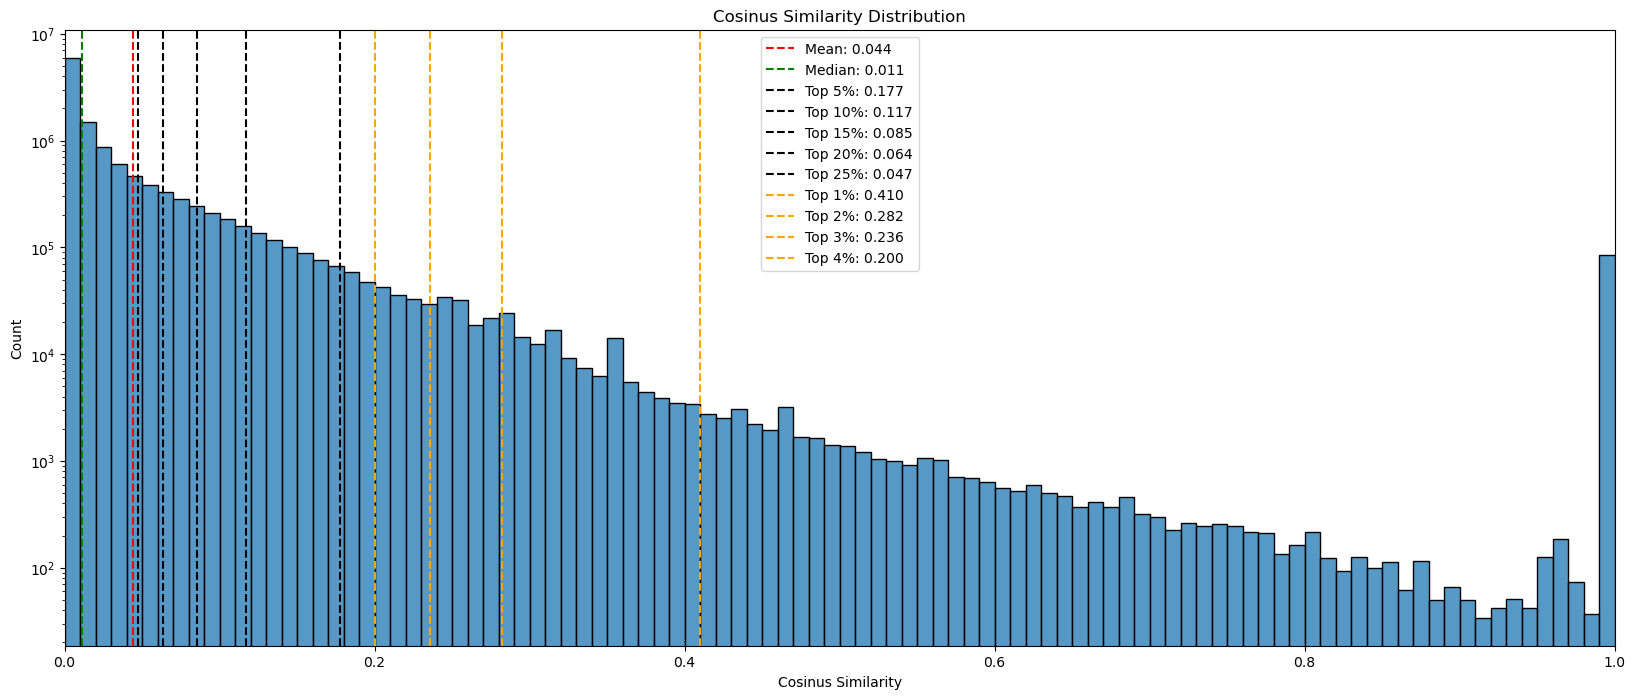

In [24]:
plt.figure(figsize=(20, 8))
sns.histplot(collection_of_values, bins=100, kde=False)

plt.yscale('log')
plt.xlim(0, 1)

plt.axvline(x=mean_cov, color='red', linestyle='--', label=f'Mean: {mean_cov:.3f}')
plt.axvline(x=median_cov, color='green', linestyle='--', label=f'Median: {median_cov:.3f}')

plt.axvline(x=top_5, color='black', linestyle='--', label=f'Top 5%: {top_5:.3f}')
plt.axvline(x=top_10, color='black', linestyle='--', label=f'Top 10%: {top_10:.3f}')
plt.axvline(x=top_15, color='black', linestyle='--', label=f'Top 15%: {top_15:.3f}')
plt.axvline(x=top_20, color='black', linestyle='--', label=f'Top 20%: {top_20:.3f}')
plt.axvline(x=top_25, color='black', linestyle='--', label=f'Top 25%: {top_25:.3f}')

plt.axvline(x=top_1, color='orange', linestyle='--', label=f'Top 1%: {top_1:.3f}')
plt.axvline(x=top_2, color='orange', linestyle='--', label=f'Top 2%: {top_2:.3f}')
plt.axvline(x=top_3, color='orange', linestyle='--', label=f'Top 3%: {top_3:.3f}')
plt.axvline(x=top_4, color='orange', linestyle='--', label=f'Top 4%: {top_4:.3f}')

plt.title("Cosinus Similarity Distribution")
plt.xlabel("Cosinus Similarity")
plt.ylabel("Count")

plt.legend()
plt.show()

In [ ]:
def getting_top_n_pairs(x, n):
    dic = {}
    for df_index, row in grouped_by_target.iterrows():
        
        dic.update(row.cosinus_similarity_by_pairs)
    for i in range(x.shape[0]):
        for j in range(i+1, x.shape[1]):
            dic[(i, j)] = x[i, j]
    sorted_dic = sorted(dic.items(), key=lambda item: item[1], reverse=True)
    return sorted_dic[:n]

In [ ]:
def get_cossim_pairs_stats(x):
    return x.values()

In [ ]:
grouped_by_target['Stats'] = grouped_by_target.cosinus_similarity_by_pairs.apply(get_cossim_pairs_stats)

In [ ]:
temp = grouped_by_target.Stats.iloc[0]
temp

In [ ]:
grouped_by_target

### Topic Modeling

# Work in progress